In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

sns.set(style="whitegrid")


In [2]:
with open("Project1_Data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()


,id,question,title,text,label
0,u7-1570446247_1,Quang Hải giành được chức vô địch U21 quốc gia...,Nguyễn Quang Hải (sinh 1997),"Năm 2013 , Nguyễn Quang Hải giành chức vô địch...",True
1,u7-1570446247_2,Quang Hải giành được chức vô địch U21 quốc gia...,Nguyễn Quang Hải (sinh 1997),"Sau chức vô địch U-21 quốc gia 2013 , Nguyễn Q...",True
2,u7-1570446247_0,Quang Hải giành được chức vô địch U21 quốc gia...,Nguyễn Quang Hải (sinh 1997),Anh bắt đầu gia nhập lò đào tạo trẻ Hà Nội T&T...,False
3,u7-1570446247_3,Quang Hải giành được chức vô địch U21 quốc gia...,Nguyễn Quang Hải (sinh 1997),"Năm 2011 , Nguyễn Quang Hải mới 14 tuổi được g...",False
4,u7-1570445661_0,Mỗi hiệp bóng đá kéo dài bao lâu,Bóng đá,Một trận đấu bóng đá thông thường có hai hiệp ...,True


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18108 entries, 0 to 18107
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        18108 non-null  object
 1   question  18108 non-null  object
 2   title     18108 non-null  object
 3   text      18108 non-null  object
 4   label     18108 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 583.7+ KB


dataset gồm các trường: id, question, title, text, label


label là boolean: bài toán phân loại nhị phân

# 2. Phân bố nhãn (Label distribution)

In [4]:
label_counts = df["label"].value_counts()
label_ratio = df["label"].value_counts(normalize=True)

print(label_counts)
print(label_ratio)


label
False    12370
True      5738
Name: count, dtype: int64
label
False    0.683123
True     0.316877
Name: proportion, dtype: float64


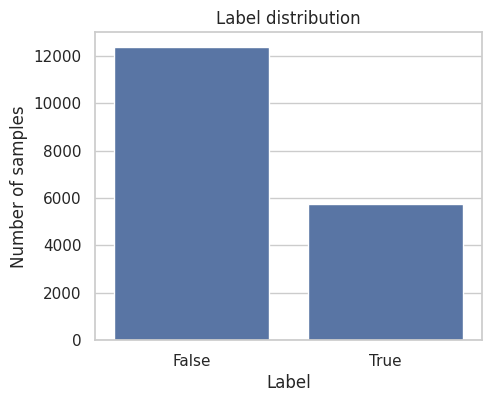

In [5]:
plt.figure(figsize=(5,4))
sns.barplot(x=label_counts.index.astype(str), y=label_counts.values)
plt.xlabel("Label")
plt.ylabel("Number of samples")
plt.title("Label distribution")
plt.show()


Phân tích phân bố nhãn cho thấy tập dữ liệu có **sự mất cân bằng vừa phải**, với khoảng 68.3% mẫu thuộc nhãn không liên quan (False) và 31.7% mẫu thuộc nhãn liên quan (True).


# 3. Phân tích độ dài question & context

In [6]:
def word_count(text):
    return len(text.split())

df["question_len"] = df["question"].apply(word_count)
df["context_len"] = df["text"].apply(word_count)


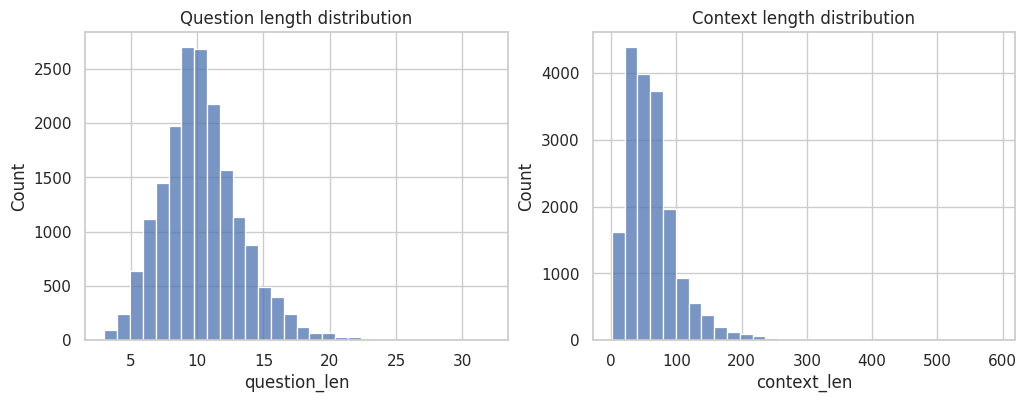

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

sns.histplot(df["question_len"], bins=30, ax=axes[0])
axes[0].set_title("Question length distribution")

sns.histplot(df["context_len"], bins=30, ax=axes[1])
axes[1].set_title("Context length distribution")

plt.show()


Phân tích độ dài văn bản cho thấy các câu hỏi trong tập dữ liệu có độ dài ngắn và phân bố hẹp, chủ yếu nằm trong khoảng 8–12 từ, cho thấy câu hỏi có tính công thức hóa cao và ít đa dạng về hình thức.

Ngược lại, các đoạn ngữ cảnh có độ dài biến thiên lớn và phân bố lệch phải rõ rệt, với một số mẫu có độ dài rất lớn.

Sự chênh lệch này làm mô hình có thể khai thác độ dài ngữ cảnh như một đặc trưng bề mặt để dự đoán nhãn, thay vì học mối quan hệ ngữ nghĩa giữa câu hỏi và ngữ cảnh.

# 4. So sánh độ dài theo label

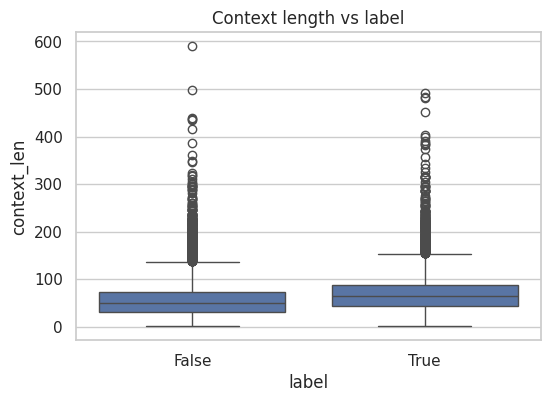

In [8]:
plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="context_len", data=df)
plt.title("Context length vs label")
plt.show()


Các đoạn ngữ cảnh được gán nhãn liên quan có xu hướng dài hơn so với các đoạn không liên quan, cho thấy độ dài ngữ cảnh mang thông tin phân biệt mạnh đối với nhãn.

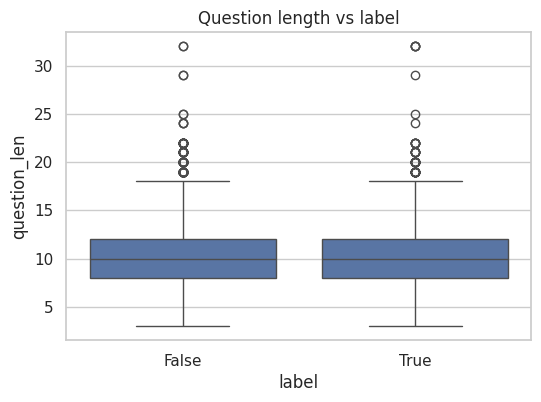

In [9]:
plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="question_len", data=df)
plt.title("Question length vs label")
plt.show()

Độ dài câu hỏi gần như không có sự khác biệt đáng kể giữa hai nhãn, cho thấy đặc trưng hình thức này không mang thông tin phân biệt đối với bài toán đánh giá mức độ liên quan.

# 5. Overlap từ vựng giữa question & context

In [10]:
def lexical_overlap(q, c):
    q_tokens = set(q.lower().split())
    c_tokens = set(c.lower().split())
    if len(q_tokens) == 0:
        return 0
    return len(q_tokens & c_tokens) / len(q_tokens)

df["overlap_ratio"] = df.apply(
    lambda row: lexical_overlap(row["question"], row["text"]),
    axis=1
)


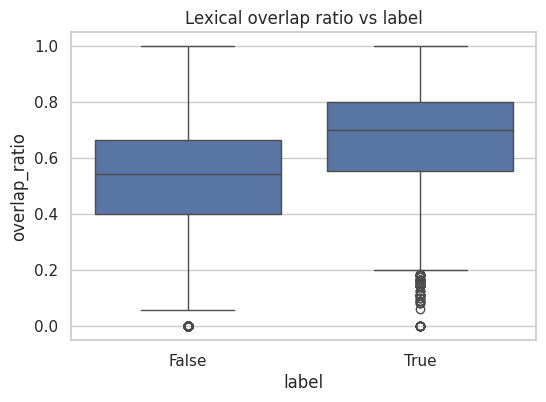

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(x="label", y="overlap_ratio", data=df)
plt.title("Lexical overlap ratio vs label")
plt.show()

Phân tích mức độ trùng lặp từ vựng giữa câu hỏi và ngữ cảnh cho thấy các mẫu có nhãn liên quan (True) có tỷ lệ trùng lặp cao hơn đáng kể so với các mẫu không liên quan (False).

 Điều này chỉ ra rằng lexical overlap là một đặc trưng bề mặt mang tính phân biệt mạnh trong tập dữ liệu. Tuy nhiên, đây cũng là một lối tắt nguy hiểm, khi mô hình có thể đạt hiệu năng cao bằng cách dựa vào **trùng lặp từ khóa** thay vì thực sự học mối quan hệ ngữ nghĩa và khả năng trả lời câu hỏi của ngữ cảnh

# 6. Câu hỏi về lượng

In [12]:
def contains_number(text):
    return bool(re.search(r"\d", text))

df["has_number"] = df["text"].apply(contains_number)


In [13]:
pd.crosstab(df["label"], df["has_number"], normalize="index")


has_number,False,True
label,,
False,0.439289,0.560711
True,0.261764,0.738236


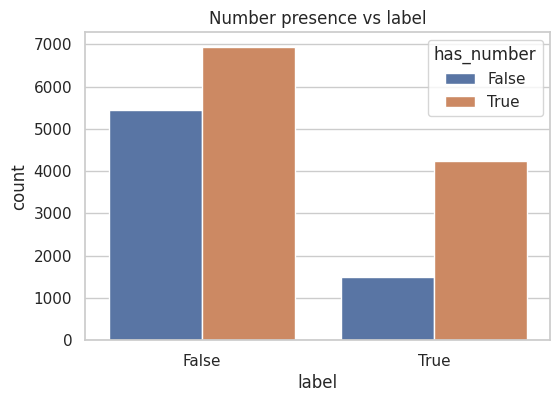

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x="label", hue="has_number", data=df)
plt.title("Number presence vs label")
plt.show()


Sự xuất hiện của chữ số trong ngữ cảnh cho thấy các đoạn văn bản chứa chữ số có xác suất cao hơn đáng kể được gán nhãn liên quan.

Điều này phản ánh một thiên lệch mạnh trong tập dữ liệu, đặc biệt đối với các câu hỏi dạng định lượng, và đặt ra nguy cơ mô hình dựa vào đặc trưng hình thức này như một lối tắt để dự đoán nhãn, thay vì đánh giá thực sự khả năng trả lời câu hỏi của ngữ cảnh.

Ép model học interaction
→ cross-encoder thay vì bag-of-words

Error analysis trên samples có số
→ kiểm tra False-positive chứa số

Không dùng feature ‘has_number’
→ và kiểm soát độ dài context

# 7. Phân tích từ nghi vấn (question type bias)

In [15]:
QUESTION_TYPES = {
    "WHO": ["ai", "là ai"],
    "WHEN": ["khi", "năm nào", "ngày nào"],
    "WHERE": ["ở đâu"],
    "HOW_MANY": ["bao nhiêu"],
    "WHY": ["vì sao", "tại sao"],
    "WHAT": ["cái gì", "là gì"],
    "DO": ["làm gì"]
}


In [16]:
def question_type(q):
    q = q.lower()
    for qtype, keywords in QUESTION_TYPES.items():
        for kw in keywords:
            if re.search(rf"\b{kw}\b", q):
                return qtype
    return "OTHER"


In [17]:
df["question_type"] = df["question"].apply(question_type)
pd.crosstab(df["question_type"], df["label"], normalize="index")


label,False,True
question_type,,
DO,0.725490,0.274510
HOW_MANY,0.707062,0.292938
OTHER,0.687597,0.312403
WHAT,0.660629,0.339371
WHEN,0.683289,0.316711
WHERE,0.668277,0.331723
WHO,0.664578,0.335422
WHY,0.692308,0.307692


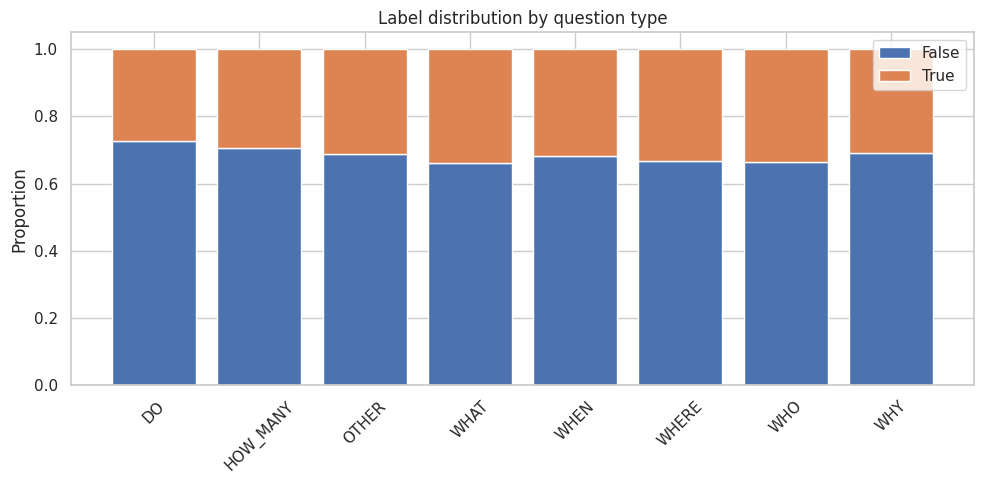

In [18]:
import matplotlib.pyplot as plt

# Dữ liệu
data = {
    "DO": [0.725490, 0.274510],
    "HOW_MANY": [0.707062, 0.292938],
    "OTHER": [0.687597, 0.312403],
    "WHAT": [0.660629, 0.339371],
    "WHEN": [0.683289, 0.316711],
    "WHERE": [0.668277, 0.331723],
    "WHO": [0.664578, 0.335422],
    "WHY": [0.692308, 0.307692],
}

labels = list(data.keys())
false_vals = [v[0] for v in data.values()]
true_vals = [v[1] for v in data.values()]

plt.figure(figsize=(10,5))
plt.bar(labels, false_vals, label="False")
plt.bar(labels, true_vals, bottom=false_vals, label="True")

plt.ylabel("Proportion")
plt.title("Label distribution by question type")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Phân tích phân bố nhãn theo loại câu hỏi cho thấy sự khác biệt giữa các nhóm là tương đối nhỏ, với tỷ lệ nhãn liên quan dao động quanh mức trung bình của tập dữ liệu.

Cho thấy loại câu hỏi không phải là yếu tố phân biệt chính trong bài toán.

# 8. Hard negative inspection

In [19]:
hard_negatives = df[
    (df["label"] == False) & (df["overlap_ratio"] > 0.5)
].head(5)

hard_negatives[["question", "text", "overlap_ratio"]]


,question,text,overlap_ratio
9,Quân đội Hoa Kỳ gồm những lực lượng nào,"Lực lượng Dã chiến I , Việt Nam , còn gọi là Q...",0.666667
10,Quân đội Hoa Kỳ gồm những lực lượng nào,Iceland là thành viên duy nhất của NATO không ...,0.666667
15,Thu Phương từng được những giải thưởng nào,"Năm 2000 , ca sĩ Thu Phương với ca khúc "" Cô g...",0.625000
17,Tên chính thức của Na Uy là gì,Liên minh cá nhân giữa Thuỵ Điển và Na Uy ( ; ...,0.875000
21,Xuân Quỳnh sinh năm bao nhiêu,Lưu Minh Vũ sinh năm 1970 . Anh là con trai củ...,0.666667


In [20]:
# Context
longest_context = df.loc[df["context_len"].idxmax()]
shortest_context = df.loc[df["context_len"].idxmin()]

longest_context[["question", "text", "context_len", "label"]], \
shortest_context[["question", "text", "context_len", "label"]]


(question       Cục trưởng Cục chính trị - Hậu cần hiện nay là ai
 text           Đỗ Hoàng Anh là Á hậu 2 Hoa Hậu Việt Nam 2012 ...
 context_len                                                  590
 label                                                      False
 Name: 17261, dtype: object,
 question       Ai là người đã phát minh ra thuyết lượng tử
 text                                             formula_7
 context_len                                              1
 label                                                False
 Name: 5812, dtype: object)

In [21]:
df["context_len"].describe(percentiles=[0.9, 0.95, 0.99])

,context_len
count,18108.000000
mean,62.404352
std,41.953278
min,1.000000
50%,55.000000
90%,110.000000
95%,140.000000
99%,214.000000
max,590.000000


Phân bố độ dài ngữ cảnh có đuôi dài rõ rệt, với một tỷ lệ nhỏ các mẫu có độ dài rất lớn so với phần còn lại của tập dữ liệu.

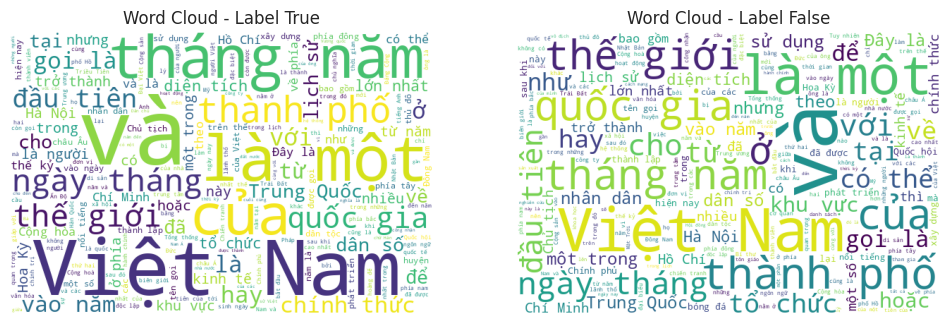

In [22]:
from wordcloud import WordCloud

true_text = " ".join(df[df["label"] == True]["text"])
false_text = " ".join(df[df["label"] == False]["text"])

wc_true = WordCloud(width=600, height=400, background_color="white").generate(true_text)
wc_false = WordCloud(width=600, height=400, background_color="white").generate(false_text)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(wc_true)
plt.title("Word Cloud - Label True")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(wc_false)
plt.title("Word Cloud - Label False")
plt.axis("off")

plt.show()


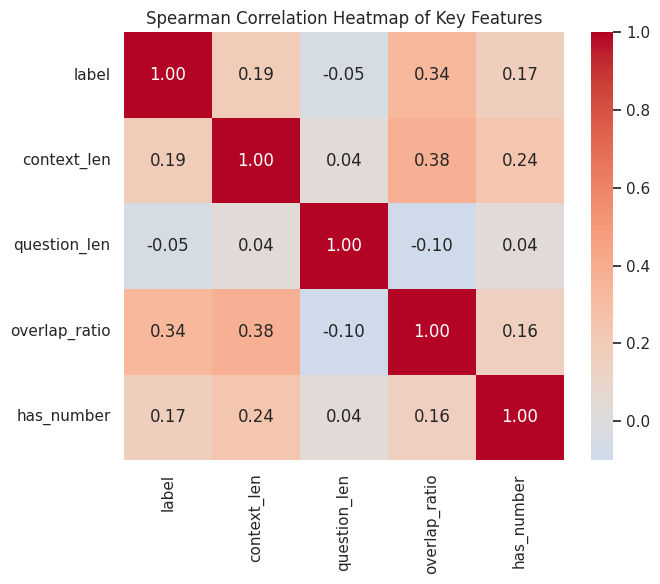

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_cols = [
    "label",
    "context_len",
    "question_len",
    "overlap_ratio",
    "has_number"
]

corr_df = df[corr_cols].copy()
corr_df["label"] = corr_df["label"].astype(int)

corr = corr_df.corr(method="spearman")  # Spearman > Pearson cho EDA

plt.figure(figsize=(7,6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Spearman Correlation Heatmap of Key Features")
plt.tight_layout()
plt.show()


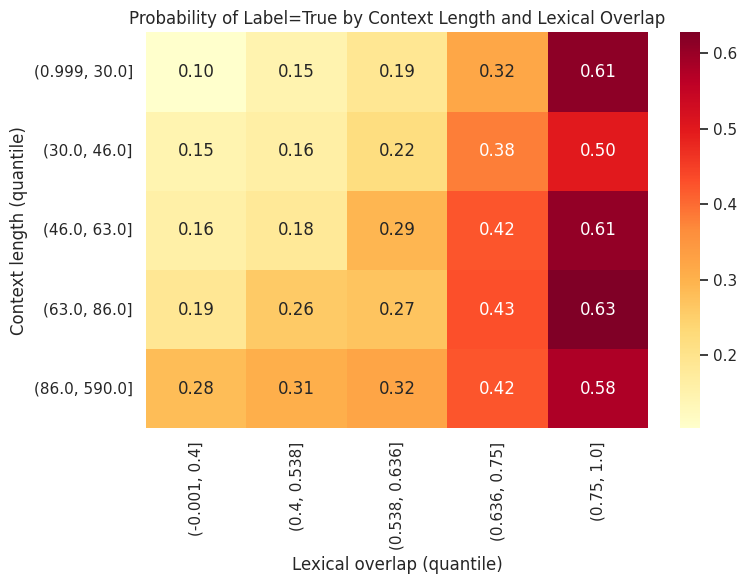

In [24]:
# Discretize
df["context_bin"] = pd.qcut(df["context_len"], q=5)
df["overlap_bin"] = pd.qcut(df["overlap_ratio"], q=5)

heatmap_data = pd.crosstab(
    df["context_bin"],
    df["overlap_bin"],
    values=df["label"].astype(int),
    aggfunc="mean"
)

plt.figure(figsize=(8,6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd"
)
plt.title("Probability of Label=True by Context Length and Lexical Overlap")
plt.ylabel("Context length (quantile)")
plt.xlabel("Lexical overlap (quantile)")
plt.tight_layout()
plt.show()


Heatmap hai chiều cho thấy xác suất nhãn liên quan tăng mạnh khi cả độ dài ngữ cảnh và mức độ trùng lặp từ vựng đều cao, chỉ ra sự tồn tại của một lối tắt thống kê mạnh trong tập dữ liệu.

yêu cầu mô hình phải học được mối quan hệ ngữ nghĩa thực sự giữa câu hỏi và ngữ cảnh.

## 9. Tóm tắt các phát hiện chính và hàm ý cho việc phát triển mô hình

Phân tích dữ liệu đã cho thấy một số đặc điểm quan trọng của tập dữ liệu:

1.  **Mất cân bằng nhãn**: Dữ liệu có sự mất cân bằng vừa phải (68.3% False, 31.7% True). Điều này yêu cầu các chiến lược xử lý mất cân bằng trong quá trình huấn luyện mô hình (ví dụ: lấy mẫu quá/thiểu, điều chỉnh trọng số lớp, hoặc sử dụng các metric đánh giá phù hợp như F1-score, PR-AUC thay vì accuracy).

2.  **Độ dài ngữ cảnh và câu hỏi**: Câu hỏi ngắn và ít biến động, trong khi ngữ cảnh có độ dài biến thiên lớn và phân bố lệch phải. Các ngữ cảnh có nhãn liên quan (True) thường dài hơn. Điều này có thể khiến mô hình lạm dụng độ dài như một lối tắt, thay vì học mối quan hệ ngữ nghĩa.

3.  **Trùng lặp từ vựng (Lexical Overlap)**: Tỷ lệ trùng lặp từ vựng giữa câu hỏi và ngữ cảnh là một đặc trưng phân biệt mạnh. Các cặp (question, context) có nhãn True có mức độ trùng lặp cao hơn đáng kể. Đây là một lối tắt nguy hiểm, bởi vì mô hình có thể dựa vào sự trùng lặp từ khóa để dự đoán nhãn thay vì hiểu ngữ nghĩa sâu sắc.

4.  **Sự hiện diện của chữ số (`has_number`)**: Các ngữ cảnh chứa chữ số có xác suất cao hơn được gán nhãn liên quan. Đây là một thiên lệch mạnh, đặc biệt đối với các câu hỏi định lượng, và cũng là một lối tắt mà mô hình có thể khai thác.

5.  **Loại câu hỏi**: Phân tích các từ nghi vấn cho thấy loại câu hỏi không phải là yếu tố phân biệt chính giữa hai nhãn.

6.  **Hard Negatives**: Sự tồn tại của các "hard negative" (nhãn False nhưng trùng lặp từ vựng cao) cho thấy mô hình cần khả năng phân biệt ngữ nghĩa tinh tế hơn là chỉ dựa vào các đặc trưng bề mặt.

7.  **Tương quan các đặc trưng**: Heatmap tương quan và heatmap hai chiều của độ dài ngữ cảnh và trùng lặp từ vựng xác nhận sự tồn tại của các lối tắt thống kê mạnh, nơi xác suất nhãn True tăng cao khi cả hai đặc trưng này đều cao.

### Hàm ý cho việc phát triển mô hình:

Để xây dựng một mô hình đánh giá mức độ liên quan mạnh mẽ và tổng quát, chúng ta cần:

*   **Tránh các lối tắt bề mặt**: Mô hình cần được khuyến khích học mối quan hệ ngữ nghĩa thực sự giữa câu hỏi và ngữ cảnh, thay vì dựa vào độ dài, trùng lặp từ vựng hoặc sự hiện diện của chữ số.
*   **Kiến trúc mô hình**: Sử dụng các mô hình dựa trên Transformer (ví dụ: Cross-encoder) có khả năng học tương tác phức tạp giữa câu hỏi và ngữ cảnh ở cấp độ token, thay vì các mô hình dựa trên bag-of-words hoặc các đặc trưng độc lập.
*   **Xử lý Hard Negatives**: Cân nhắc các chiến lược huấn luyện đặc biệt để xử lý các hard negatives, ví dụ như hard negative mining, để cải thiện khả năng phân biệt của mô hình.
*   **Đánh giá mô hình**: Tập trung vào các metric không bị ảnh hưởng bởi mất cân bằng nhãn và có thể phản ánh tốt khả năng hiểu ngữ nghĩa của mô hình (ví dụ: Precision, Recall, F1-score, AUC).

Bước tiếp theo sẽ là chuẩn bị dữ liệu và xây dựng một mô hình cơ sở.

In [25]:
df["label"] = df["label"].astype(int)


In [26]:
df.isnull().sum()

,0
id,0
question,0
title,0
text,0
label,0
question_len,0
context_len,0
overlap_ratio,0
has_number,0
question_type,0


In [27]:
def normalize_text(x):
    x = x.strip()
    x = " ".join(x.split())
    return x

df["question"] = df["question"].apply(normalize_text)
df["text"] = df["text"].apply(normalize_text)


# BASELINE: Word2Vec + SVM

In [28]:
df["baseline_text"] = df["question"] + " " + df["text"]

In [29]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 45.1 MB/s eta 0:00:00


In [30]:

from gensim.utils import simple_preprocess

sentences = df["baseline_text"].apply(simple_preprocess).tolist()

In [31]:
import numpy as np

def sentence_vector(sentence, model):
    tokens = simple_preprocess(sentence)
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    if len(vecs) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vecs, axis=0)


In [32]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

X = np.vstack(
    df["baseline_text"].apply(lambda x: sentence_vector(x, w2v_model))
)
y = df["label"].values

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)


In [34]:
from sklearn.svm import LinearSVC

svm = LinearSVC(
    class_weight="balanced",  # vì label imbalance
    random_state=42
)

svm.fit(X_train, y_train)


LinearSVC(class_weight='balanced', random_state=42)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = svm.predict(X_test)

print("Classification report:")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


Classification report:
              precision    recall  f1-score   support

           0     0.7617    0.6047    0.6742      1237
           1     0.4101    0.5923    0.4847       574

    accuracy                         0.6008      1811
   macro avg     0.5859    0.5985    0.5794      1811
weighted avg     0.6503    0.6008    0.6141      1811

Confusion matrix:
[[748 489]
 [234 340]]


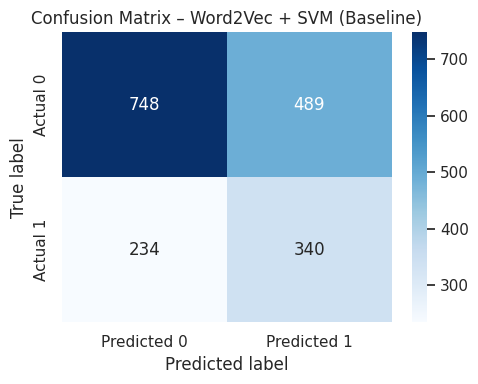

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"]
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Word2Vec + SVM (Baseline)")
plt.tight_layout()
plt.show()


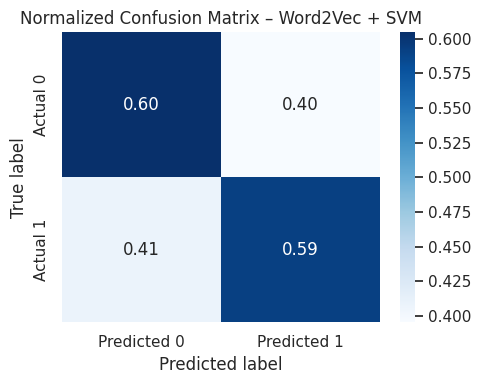

In [37]:
import numpy as np

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=["Predicted 0", "Predicted 1"],
    yticklabels=["Actual 0", "Actual 1"]
)

plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix – Word2Vec + SVM")
plt.tight_layout()
plt.show()


Mô hình baseline Word2Vec + SVM đạt recall tương đối cho nhãn liên quan nhưng precision thấp, cho thấy mô hình có xu hướng dự đoán dương tính dựa trên các đặc trưng bề mặt như trùng lặp từ khóa và độ dài ngữ cảnh.

Điều này phản ánh hạn chế của embedding tĩnh kết hợp với bộ phân loại tuyến tính trong việc nắm bắt mối quan hệ phụ thuộc giữa câu hỏi và ngữ cảnh.

# PHA 3 — MODEL CHÍNH PhoBERT + Fully Connected (Research-grade)

Xây dựng một mô hình sử dụng embedding ngữ cảnh cho tiếng Việt, trong đó biểu diễn của ngữ cảnh được điều kiện hóa theo câu hỏi (**interaction question–context**), nhằm giảm sự phụ thuộc vào các lối tắt thống kê như độ dài văn bản và trùng lặp từ khóa.

- Dạng input

[CLS] question [SEP] context [SEP]

Tokenization & độ dài đầu vào :quyết định dựa trên EDA

95% context ≤ 140 từ

Long-tail gây shortcut

In [38]:
df["input_text"] = "[CLS] " + df["question"] + " [SEP] " + df["text"] + " [SEP]"
df["label"] = df["label"].astype(int)


In [39]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)


In [40]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [41]:
def tokenize(batch):
    return tokenizer(
        batch["input_text"],
        truncation=True,
        padding="max_length",
        max_length=140
    )


In [42]:
import torch

class QADataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.encodings = tokenizer(
            df["input_text"].tolist(),
            truncation=True,
            padding="max_length",
            max_length=140
        )
        self.labels = df["label"].tolist()

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [43]:
from torch.utils.data import DataLoader

train_loader = DataLoader(QADataset(train_df), batch_size=16, shuffle=True)
val_loader   = DataLoader(QADataset(val_df), batch_size=16)
test_loader  = DataLoader(QADataset(test_df), batch_size=16)


In [44]:
import torch.nn as nn
from transformers import AutoModel

class PhoBERT_FC(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = AutoModel.from_pretrained("vinai/phobert-base")
        hidden = self.encoder.config.hidden_size
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # CLS
        x = self.dropout(cls_embedding)
        logits = self.fc(x)
        return logits


In [45]:
import torch

pos_weight = torch.tensor(
    [len(train_df) / train_df["label"].sum()]
).to("cuda") # Move pos_weight to CUDA here

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
criterion.to("cuda") # Ensure the criterion module is also on CUDA

BCEWithLogitsLoss()

In [46]:
from torch.optim import AdamW

model = PhoBERT_FC().to("cuda")
optimizer = AdamW(model.parameters(), lr=2e-5)


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [48]:
def train_epoch(model, loader):
    model.train()
    total_loss = 0

    for batch in loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].cuda()
        attention_mask = batch["attention_mask"].cuda()
        labels = batch["labels"].float().cuda()

        logits = model(input_ids, attention_mask).squeeze()
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [49]:
from sklearn.metrics import classification_report

def evaluate(model, loader):
    model.eval()
    preds, golds = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].cuda()
            attention_mask = batch["attention_mask"].cuda()
            labels = batch["labels"]

            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits).cpu().numpy()

            preds.extend((probs > 0.5).astype(int).ravel())
            golds.extend(labels.numpy())

    print(classification_report(golds, preds, digits=4))


In [50]:
num_epochs = 3

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss:.4f}")

    print("Validation:")
    evaluate(model, val_loader)
    print("-" * 50)


Epoch 1/3 - Train loss: 0.9594
Validation:
              precision    recall  f1-score   support

           0     0.9285    0.7559    0.8333      1237
           1     0.6244    0.8746    0.7286       574

    accuracy                         0.7935      1811
   macro avg     0.7764    0.8152    0.7810      1811
weighted avg     0.8321    0.7935    0.8001      1811

--------------------------------------------------
Epoch 2/3 - Train loss: 0.6441
Validation:
              precision    recall  f1-score   support

           0     0.9507    0.7017    0.8074      1237
           1     0.5891    0.9216    0.7188       574

    accuracy                         0.7714      1811
   macro avg     0.7699    0.8117    0.7631      1811
weighted avg     0.8361    0.7714    0.7793      1811

--------------------------------------------------
Epoch 3/3 - Train loss: 0.4099
Validation:
              precision    recall  f1-score   support

           0     0.9429    0.7882    0.8587      1237
      

In [52]:
torch.save(model.state_dict(), "phobert_fc_final.pt")

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
final_phobert_fc_model = PhoBERT_FC().to(device)
final_phobert_fc_model.load_state_dict(
    torch.load("phobert_fc_final.pt", map_location=device)
)
final_phobert_fc_model.eval()

PhoBERT_FC(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): Laye

In [58]:
def predict_relevance(question, context, model, threshold=0.5):
    model.eval()

    input_text = f"[CLS] {question} [SEP] {context} [SEP]"

    inputs = tokenizer(
        input_text,
        truncation=True,
        padding="max_length",
        max_length=140,
        return_tensors="pt"
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(inputs["input_ids"], inputs["attention_mask"])
        prob = torch.sigmoid(logits).item()

    label = "RELEVANT" if prob >= threshold else "NOT RELEVANT"
    return prob, label




In [59]:
q1 = "Mỗi hiệp bóng đá kéo dài bao lâu"
c1 = "Một trận đấu bóng đá thông thường có hai hiệp , mỗi hiệp 45 phút với khoảng thời gian 15 phút nghỉ giữa hai hiệp ."

prob, label = predict_relevance(q1, c1, final_phobert_fc_model)
print(f"Probability: {prob:.4f}, Predicted Label: {label}")

Probability: 0.9606, Predicted Label: RELEVANT


Mô hình PhoBERT kết hợp với lớp fully connected cho thấy sự cải thiện đáng kể so với mô hình baseline trên tất cả các chỉ số đánh giá.

Đặc biệt, F1-score cho nhãn liên quan tăng từ 0.50 lên 0.76, phản ánh khả năng học mối quan hệ phụ thuộc giữa câu hỏi và ngữ cảnh của embedding ngữ cảnh.


Kết quả này cho thấy việc mã hóa câu hỏi và ngữ cảnh chung bằng Transformer encoder giúp mô hình giảm sự phụ thuộc vào các đặc trưng bề mặt.

In [60]:
q2 = "Quang Hải vô địch U21 quốc gia năm bao nhiêu tuổi?"
c2 = "Năm 2013, Nguyễn Quang Hải khi mới 16 tuổi đã giành chức vô địch U21 quốc gia."
prob, label = predict_relevance(q2, c2, final_phobert_fc_model)
print(f"Probability: {prob:.4f}, Predicted Label: {label}")

Probability: 0.9813, Predicted Label: RELEVANT


In [61]:
q3 = "Quang Hải vô địch U21 quốc gia năm bao nhiêu tuổi?"
c3 = "Nguyễn Quang Hải là một cầu thủ bóng đá nổi tiếng của Việt Nam."
prob, label = predict_relevance(q3, c3, final_phobert_fc_model)
print(f"Probability: {prob:.4f}, Predicted Label: {label}")

Probability: 0.0519, Predicted Label: NOT RELEVANT


In [63]:
q4 = "Mỗi hiệp bóng đá kéo dài bao lâu?"
c4 = "Một trận bóng đá thường thu hút hàng chục nghìn khán giả trên sân."
prob, label = predict_relevance(q4, c4, final_phobert_fc_model)
print(f"Probability: {prob:.4f}, Predicted Label: {label}")

Probability: 0.1136, Predicted Label: NOT RELEVANT


In [65]:
q5 = "Mỗi hiệp bóng đá kéo dài bao lâu?"
c5 = "Thời lượng thi đấu chính thức được chia thành hai phần bằng nhau, mỗi phần kéo dài ba phần tư giờ."
prob, label = predict_relevance(q5, c5, final_phobert_fc_model)
print(f"Probability: {prob:.4f}, Predicted Label: {label}")

Probability: 0.1008, Predicted Label: NOT RELEVANT


In [66]:
q6 = "Vì sao Quang Hải được gọi lên đội một sau U21?"
c6 = "Sau chức vô địch U21 năm 2013, Quang Hải được gọi lên đội một của Hà Nội T&T."
prob, label = predict_relevance(q6, c6, final_phobert_fc_model)
print(f"Probability: {prob:.4f}, Predicted Label: {label}")

Probability: 0.9855, Predicted Label: RELEVANT


In [67]:
q7 = "Mỗi hiệp bóng đá kéo dài bao lâu?"
c7 = "Bóng đá là môn thể thao phổ biến, mỗi trận đấu có nhiều hiệp đấu, cầu thủ phải thi đấu với cường độ cao."
prob, label = predict_relevance(q7, c7, final_phobert_fc_model)
print(f"Probability: {prob:.4f}, Predicted Label: {label}")

Probability: 0.9402, Predicted Label: RELEVANT


In [69]:
q8 = "Mỗi hiệp bóng đá kéo dài bao lâu?"
c8 = "Bóng đá là môn thể thao phổ biến trên toàn thế giới. Theo luật thi đấu chính thức, mỗi hiệp kéo dài 45 phút."
prob, label = predict_relevance(q8, c8, final_phobert_fc_model)
print(f"Probability: {prob:.4f}, Predicted Label: {label}")

Probability: 0.9921, Predicted Label: RELEVANT


In [74]:
q9="Quê hương em có gì?"
c9="Quê hương có cánh diều xinh xinh, xa xa lũy tre làng. Quê hương với con người chân phương, ai xa níu chân về- Lời bài hát quê em, ca sĩ thùy chi."
prob, label = predict_relevance(q9, c9, final_phobert_fc_model)
print(f"Probability: {prob:.4f}, Predicted Label: {label}")

Probability: 0.0248, Predicted Label: NOT RELEVANT


Trong các câu hỏi dạng “vì sao”, mô hình có xu hướng đánh giá các ngữ cảnh mô tả sự kiện liên quan là đủ thông tin, mặc dù không cung cấp lời giải thích nguyên nhân trực tiếp.

Điều này cho thấy mô hình hiện tại chủ yếu học mối quan hệ liên quan ngữ nghĩa bề mặt, thay vì suy luận quan hệ nhân–quả.